In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import xgboost as xgb


Load dataset

In [46]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

print("Original shape:", df.shape)
print("Fraud percentage:", df["isFraud"].mean())


Original shape: (1819084, 11)
Fraud percentage: 0.0010268910214652107


BASIC RENAME + TIMESTAMP

In [47]:
df = df.rename(columns={
    "nameOrig": "user_id",
    "nameDest": "dest_id"
})

start_time = pd.to_datetime("2026-01-01 00:00:00")
df["timestamp"] = start_time + pd.to_timedelta(df["step"], unit="h")

FAST DEVICE ASSIGNMENT (VECTORISED)

In [48]:
# Base device per user
df["device_id"] = (
    df["user_id"] + "_D_" +
    np.random.randint(0, 3, size=len(df)).astype(str)
)

# Inject new device for some fraud rows
fraud_mask = df["isFraud"] == 1
new_device_mask = fraud_mask & (np.random.rand(len(df)) < 0.4)

df.loc[new_device_mask, "device_id"] = (
    "NEW_" + np.random.randint(10000, 99999, size=new_device_mask.sum()).astype(str)
)

FAST GEO ASSIGNMENT (VECTORISED)


In [49]:
cities = [
    (19.0760, 72.8777),   # Mumbai
    (28.7041, 77.1025),   # Delhi
    (12.9716, 77.5946),   # Bangalore
    (22.5726, 88.3639)    # Kolkata
]

unique_users = df["user_id"].unique()
user_city_map = {
    user: cities[np.random.randint(0, len(cities))]
    for user in unique_users
}

df["base_lat"] = df["user_id"].map(lambda x: user_city_map[x][0])
df["base_lon"] = df["user_id"].map(lambda x: user_city_map[x][1])

# Normal noise
df["latitude"] = df["base_lat"] + np.random.uniform(-0.02, 0.02, len(df))
df["longitude"] = df["base_lon"] + np.random.uniform(-0.02, 0.02, len(df))

# Fraud jump city
jump_mask = fraud_mask & (np.random.rand(len(df)) < 0.5)
random_cities = np.random.randint(0, len(cities), size=jump_mask.sum())

df.loc[jump_mask, "latitude"] = [cities[i][0] for i in random_cities]
df.loc[jump_mask, "longitude"] = [cities[i][1] for i in random_cities]

KEEP ALL FRAUD USERS + SAMPLE 100K LEGIT USERS

In [50]:
fraud_users = df[df["isFraud"] == 1]["user_id"].unique()
fraud_data = df[df["user_id"].isin(fraud_users)]

legit_users = df[~df["user_id"].isin(fraud_users)]["user_id"].drop_duplicates()
sample_legit_users = legit_users.sample(100000, random_state=42)

legit_data = df[df["user_id"].isin(sample_legit_users)]

df = pd.concat([fraud_data, legit_data]).copy()

print("After sampling shape:", df.shape)
print("Fraud percentage:", df["isFraud"].mean())


After sampling shape: (101925, 17)
Fraud percentage: 0.01832720137355899


SORT FOR BEHAVIOR

In [51]:
df = df.sort_values(["user_id", "timestamp"])

FEATURE ENGINEERING

In [52]:
# Expanding mean (fast & no leakage)
df["user_avg_amount"] = (
    df.groupby("user_id")["amount"]
    .transform(lambda x: x.shift().expanding().mean())
)

df["amount_deviation"] = df["amount"] / df["user_avg_amount"]

# Time difference
df["time_diff_minutes"] = (
    df.groupby("user_id")["timestamp"]
    .diff()
    .dt.total_seconds() / 60
)

# Device change
df["prev_device"] = df.groupby("user_id")["device_id"].shift()
df["device_changed"] = (df["device_id"] != df["prev_device"]).astype(int)

# Night flag
df["hour"] = df["timestamp"].dt.hour
df["night_flag"] = (df["hour"] <= 5).astype(int)

# Fill initial NaNs safely
df["user_avg_amount"].fillna(df["amount"], inplace=True)
df["amount_deviation"].fillna(1, inplace=True)
df["time_diff_minutes"].fillna(0, inplace=True)

/tmp/ipython-input-1135937612.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["user_avg_amount"].fillna(df["amount"], inplace=True)
/tmp/ipython-input-1135937612.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

SELECT FEATURES

In [53]:
features = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "user_avg_amount",
    "amount_deviation",
    "time_diff_minutes",
    "device_changed",
    "night_flag"
]

X = df[features]
y = df["isFraud"]

In [54]:
# features = [
#     "amount",
#     "user_avg_amount",
#     "amount_deviation",
#     "time_diff_minutes",
#     "device_changed",
#     "night_flag"
# ]
# X = df[features]
# y = df["isFraud"]

TIME-BASED SPLIT

In [55]:
df = df.sort_values("timestamp")
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]


HANDLE IMBALANCE

In [56]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    max_depth=5,
    n_estimators=150,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

EVALUATION

In [57]:
y_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.8
y_pred = (y_probs > threshold).astype(int)

print(classification_report(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

print("PR-AUC:", pr_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     19993
         1.0       0.73      0.98      0.84       392

    accuracy                           0.99     20385
   macro avg       0.86      0.99      0.92     20385
weighted avg       0.99      0.99      0.99     20385

PR-AUC: 0.9550505473225019


(array([1.8616e+04, 4.4600e+02, 1.8600e+02, 6.1000e+01, 5.7000e+01,
        6.8000e+01, 3.9000e+01, 3.7000e+01, 2.3000e+01, 1.7000e+01,
        2.5000e+01, 1.9000e+01, 1.6000e+01, 1.8000e+01, 1.4000e+01,
        1.3000e+01, 6.0000e+00, 8.0000e+00, 2.5000e+01, 4.0000e+00,
        1.1000e+01, 1.4000e+01, 1.4000e+01, 9.0000e+00, 5.0000e+00,
        1.2000e+01, 7.0000e+00, 5.0000e+00, 1.3000e+01, 6.0000e+00,
        5.0000e+00, 9.0000e+00, 4.0000e+00, 1.0000e+01, 1.0000e+01,
        3.0000e+00, 2.0000e+00, 8.0000e+00, 4.0000e+00, 6.0000e+00,
        1.3000e+01, 2.1000e+01, 1.3000e+01, 9.0000e+00, 3.0000e+01,
        1.3000e+01, 2.7000e+01, 5.5000e+01, 5.0000e+01, 2.9900e+02]),
 array([1.18832304e-06, 2.00009421e-02, 4.00006957e-02, 6.00004494e-02,
        8.00001994e-02, 9.99999568e-02, 1.19999707e-01, 1.39999464e-01,
        1.59999222e-01, 1.79998979e-01, 1.99998736e-01, 2.19998479e-01,
        2.39998236e-01, 2.59997994e-01, 2.79997736e-01, 2.99997509e-01,
        3.19997251e-01, 3.3999

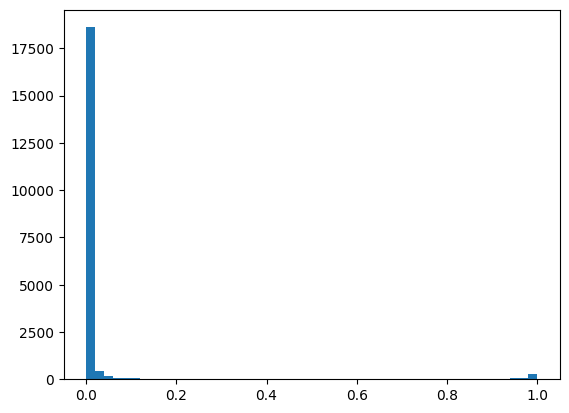

In [58]:
import matplotlib.pyplot as plt
plt.hist(y_probs, bins=50)

Risk Score Engine

In [59]:
y_probs = model.predict_proba(X_test)[:, 1]

In [60]:
risk_score = (y_probs * 100).round(2)

In [61]:
def risk_level(score):
    if score >= 80:
        return "High"
    elif score >= 40:
        return "Medium"
    else:
        return "Low"

risk_levels = [risk_level(s) for s in risk_score]

SHAP Explainability

In [62]:
!pip install shap

In [63]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.iloc[:1000])

In [64]:
i = 10  # example transaction

print("Risk Score:", risk_score[i])
print("Top contributing features:")

shap_contrib = pd.Series(shap_values[i], index=X_test.columns)
print(shap_contrib.sort_values(ascending=False).head(5))

Risk Score: 0.11
Top contributing features:
newbalanceOrig       0.632971
oldbalanceDest       0.143268
night_flag           0.020046
device_changed       0.000000
time_diff_minutes    0.000000
dtype: float32


In [65]:
def explain_transaction(index):
    prob = y_probs[index]
    score = float(round(prob * 100, 2))

    shap_contrib = pd.Series(shap_values[index], index=X_test.columns)

    positive_contrib = shap_contrib[shap_contrib > 0]
    top_features = positive_contrib.sort_values(ascending=False).head(3)

    reasons = []
    for feature in top_features.index:
        reasons.append(interpret_feature(feature))

    return score, reasons

Explanation Mapping

In [66]:
def interpret_feature(feature_name):
    explanations = {
        "amount_deviation": "Transaction amount is significantly higher than user's historical average.",
        "device_changed": "Transaction initiated from a new or different device.",
        "time_diff_minutes": "Very short time gap between consecutive transactions.",
        "oldbalanceOrg": "Unusual sender balance pattern detected.",
        "night_flag": "Transaction occurred during unusual night hours.",
        "newbalanceOrig": "Suspicious change in sender's account balance.",
        "newbalanceDest": "Unusual balance shift detected at destination account.",
        "oldbalanceDest": "Unusual shift detected in destination account balance.",
    }

    return explanations.get(feature_name, f"{feature_name} contributed to the risk score.")

In [67]:
fraud_indices = np.where(y_test.values == 1)[0][:5]

for idx in fraud_indices:
    score, reasons = explain_transaction(idx)
    print("\nTransaction Index:", idx)
    print("Risk Score:", score)
    for r in reasons:
        print("-", r)


Transaction Index: 46
Risk Score: 85.75
- Unusual sender balance pattern detected.
- Suspicious change in sender's account balance.

Transaction Index: 123
Risk Score: 99.9000015258789
- Unusual sender balance pattern detected.
- Suspicious change in sender's account balance.
- Unusual balance shift detected at destination account.

Transaction Index: 176
Risk Score: 99.11000061035156
- Unusual sender balance pattern detected.
- Transaction occurred during unusual night hours.
- Suspicious change in sender's account balance.

Transaction Index: 283
Risk Score: 99.98999786376953
- Unusual sender balance pattern detected.
- Unusual balance shift detected at destination account.
- Unusual shift detected in destination account balance.

Transaction Index: 355
Risk Score: 99.94999694824219
- Unusual sender balance pattern detected.
- Transaction occurred during unusual night hours.
- Suspicious change in sender's account balance.


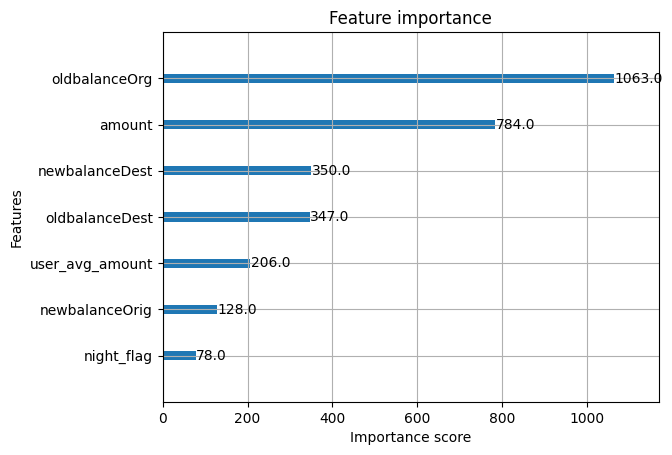

In [68]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

In [69]:
def get_risk_level(score):
    if score >= 80:
        return "High"
    elif score >= 40:
        return "Medium"
    else:
        return "Low"

In [70]:
import joblib
joblib.dump(model, "fraud_model.pkl")
joblib.dump(features, "feature_list.pkl")

['feature_list.pkl']

In [71]:
def predict_transaction(transaction, user_history):

    user_id = transaction["user_id"]
    amount = transaction["amount"]
    timestamp = pd.to_datetime(transaction["timestamp"])
    device_id = transaction["device_id"]
    input_data = input_data[features]

    # Initialize history
    if user_id not in user_history:
        user_history[user_id] = []

    history = user_history[user_id]

    # Compute behavioral features
    if len(history) == 0:
        user_avg_amount = amount
        time_diff_minutes = 0
        device_changed = 0
    else:
        previous = history[-1]
        user_avg_amount = np.mean([h["amount"] for h in history])
        time_diff_minutes = (timestamp - previous["timestamp"]).total_seconds() / 60
        device_changed = int(device_id != previous["device_id"])

    amount_deviation = amount / user_avg_amount if user_avg_amount != 0 else 1
    night_flag = int(timestamp.hour <= 5)

    input_data = pd.DataFrame([{
        "amount": amount,
        "oldbalanceOrg": transaction["oldbalanceOrg"],
        "newbalanceOrig": transaction["newbalanceOrig"],
        "oldbalanceDest": transaction["oldbalanceDest"],
        "newbalanceDest": transaction["newbalanceDest"],
        "user_avg_amount": user_avg_amount,
        "amount_deviation": amount_deviation,
        "time_diff_minutes": time_diff_minutes,
        "device_changed": device_changed,
        "night_flag": night_flag
    }])

    prob = model.predict_proba(input_data)[0][1]
    risk_score = float(round(prob * 100, 2))

    # SHAP explanation
    shap_values_single = explainer.shap_values(input_data)
    shap_contrib = pd.Series(shap_values_single[0], index=features)

    positive_contrib = shap_contrib[shap_contrib > 0]
    top_features = positive_contrib.sort_values(ascending=False).head(3)

    reasons = [interpret_feature(f) for f in top_features.index]

    # Update history
    user_history[user_id].append({
        "amount": amount,
        "timestamp": timestamp,
        "device_id": device_id
    })

    return {
        "risk_score": risk_score,
        "risk_level": get_risk_level(risk_score),
        "reasons": reasons
    }

In [72]:
import joblib
joblib.dump(model, "fraud_model.pkl")
joblib.dump(features, "feature_list.pkl")

['feature_list.pkl']

In [73]:
fraud_df = df[df["isFraud"] == 1].copy()
legit_df = df[df["isFraud"] == 0].copy()

In [74]:
fraud_sample = fraud_df.sample(n=40, random_state=42)
legit_sample = legit_df.sample(n=60, random_state=42)

In [75]:
demo_df = pd.concat([fraud_sample, legit_sample])

In [76]:
demo_df = demo_df.rename(columns={
    "nameOrig": "user_id"
})

In [77]:
demo_df["transaction_id"] = ["TX_" + str(i) for i in range(len(demo_df))]

In [78]:
base_time = pd.Timestamp("2026-01-01 00:00:00")
demo_df["timestamp"] = demo_df["step"].apply(lambda x: base_time + pd.Timedelta(hours=int(x)))

In [79]:
demo_df["device_id"] = "D1"

In [80]:
demo_df = demo_df[
    [
        "transaction_id",
        "user_id",
        "amount",
        "timestamp",
        "device_id",
        "oldbalanceOrg",
        "newbalanceOrig",
        "oldbalanceDest",
        "newbalanceDest",
        "isFraud"
    ]
]

In [81]:
demo_df = demo_df.sort_values(["user_id", "timestamp"])

In [82]:
demo_df.to_csv("demo_transactions.csv", index=False)

Isolation forest

In [83]:
from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # expected fraud ratio
    random_state=42
)

iso_model.fit(X_train)

IsolationForest(contamination=0.05, n_estimators=200, random_state=42)

In [84]:
iso_pred = iso_model.predict(X_test)
iso_pred = np.where(iso_pred == -1, 1, 0)

In [85]:
from sklearn.metrics import classification_report, roc_auc_score

print("Isolation Forest Report")
print(classification_report(y_test, iso_pred))

Isolation Forest Report
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     19993
         1.0       0.15      0.37      0.21       392

    accuracy                           0.95     20385
   macro avg       0.57      0.67      0.59     20385
weighted avg       0.97      0.95      0.96     20385



In [86]:
iso_scores = -iso_model.decision_function(X_test)

In [87]:
print("ROC-AUC:", roc_auc_score(y_test, iso_scores))

ROC-AUC: 0.7458673673540841


In [90]:
def predict_transaction(transaction, user_history):

    user_id = transaction["user_id"]
    amount = transaction["amount"]
    timestamp = pd.to_datetime(transaction["timestamp"])
    device_id = transaction["device_id"]

    # Initialize history
    if user_id not in user_history:
        user_history[user_id] = []

    history = user_history[user_id]

    # Compute behavioral features
    if len(history) == 0:
        user_avg_amount = amount
        time_diff_minutes = 0
        device_changed = 0
    else:
        previous = history[-1]
        user_avg_amount = np.mean([h["amount"] for h in history])
        time_diff_minutes = (timestamp - previous["timestamp"]).total_seconds() / 60
        device_changed = int(device_id != previous["device_id"])

    amount_deviation = amount / user_avg_amount if user_avg_amount != 0 else 1
    night_flag = int(timestamp.hour <= 5)

    input_data = pd.DataFrame([{
        "amount": amount,
        "oldbalanceOrg": transaction["oldbalanceOrg"],
        "newbalanceOrig": transaction["newbalanceOrig"],
        "oldbalanceDest": transaction["oldbalanceDest"],
        "newbalanceDest": transaction["newbalanceDest"],
        "user_avg_amount": user_avg_amount,
        "amount_deviation": amount_deviation,
        "time_diff_minutes": time_diff_minutes,
        "device_changed": device_changed,
        "night_flag": night_flag
    }])

    # XGBoost prediction
    prob = model.predict_proba(input_data)[0][1]
    risk_score = float(round(prob * 100, 2))

    # SHAP explanation
    shap_values_single = explainer.shap_values(input_data)
    shap_contrib = pd.Series(shap_values_single[0], index=features)

    positive_contrib = shap_contrib[shap_contrib > 0]
    top_features = positive_contrib.sort_values(ascending=False).head(3)

    reasons = [interpret_feature(f) for f in top_features.index]

    # Isolation Forest prediction
    iso_anomaly_score = -iso_model.decision_function(input_data)[0] # Higher score for higher anomaly
    iso_prediction_raw = iso_model.predict(input_data)[0]
    iso_prediction = 1 if iso_prediction_raw == -1 else 0 # 1 for anomaly, 0 for normal

    # Update history
    user_history[user_id].append({
        "amount": amount,
        "timestamp": timestamp,
        "device_id": device_id
    })

    return {
        "risk_score": risk_score,
        "risk_level": get_risk_level(risk_score),
        "reasons": reasons,
        "iso_anomaly_score": iso_anomaly_score,
        "iso_prediction": iso_prediction
    }

Csv processing function

In [91]:
def analyze_transactions_from_csv(csv_path):
    # 1. Load the CSV into a pandas DataFrame.
    df_transactions = pd.read_csv(csv_path)

    # 3. Convert the 'timestamp' column to datetime objects.
    df_transactions['timestamp'] = pd.to_datetime(df_transactions['timestamp'])

    # 4. Sort the DataFrame by 'user_id' and 'timestamp'
    df_transactions = df_transactions.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

    # 5. Initialize an empty dictionary, user_history, to store the transaction history for each user.
    user_history = {}

    # 6. Initialize an empty list, results, to store the output
    results = []

    # 7. Iterate through each transaction
    for index, transaction_row in df_transactions.iterrows():
        prediction_output = predict_transaction(transaction_row, user_history)
        results.append(prediction_output)

    # 8. Create a new pandas DataFrame from the results list.
    results_df = pd.DataFrame(results)

    # 9. Combine this new DataFrame with the original 'transaction_id' and 'isFraud' columns
    final_df = pd.concat([df_transactions[['transaction_id', 'isFraud']], results_df], axis=1)

    # 10. Return the combined DataFrame.
    return final_df

print("Function analyze_transactions_from_csv defined.")

Function analyze_transactions_from_csv defined.


In [92]:
processed_df = analyze_transactions_from_csv('demo_transactions.csv')
print("Processed DataFrame head:")
print(processed_df.head())
print("\nProcessed DataFrame info:")
processed_df.info()

Processed DataFrame head:
  transaction_id  isFraud  risk_score risk_level  \
0          TX_37      1.0   99.970001       High   
1          TX_96      0.0    0.020000        Low   
2           TX_0      1.0   94.769997       High   
3          TX_49      0.0    0.010000        Low   
4          TX_93      0.0   22.139999        Low   

                                             reasons  iso_anomaly_score  \
0  [Unusual sender balance pattern detected., Sus...           0.126917   
1  [Unusual sender balance pattern detected., Unu...           0.059687   
2  [Unusual sender balance pattern detected., Sus...          -0.200676   
3  [Unusual sender balance pattern detected., use...          -0.167707   
4  [Suspicious change in sender's account balance...          -0.237164   

   iso_prediction  
0               1  
1               1  
2               0  
3               0  
4               0  

Processed DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 

In [93]:
from sklearn.metrics import classification_report
import numpy as np

# XGBoost Evaluation
xgb_threshold = 0.5 # A common threshold for classification
y_true = processed_df['isFraud']
xgb_pred = (processed_df['risk_score'] / 100 > xgb_threshold).astype(int)

print("\nXGBoost Model Classification Report:")
print(classification_report(y_true, xgb_pred))

# Isolation Forest Evaluation
iso_pred = processed_df['iso_prediction']

print("\nIsolation Forest Model Classification Report:")
print(classification_report(y_true, iso_pred))


XGBoost Model Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        60
         1.0       0.98      1.00      0.99        40

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Isolation Forest Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.93      0.78        60
         1.0       0.76      0.33      0.46        40

    accuracy                           0.69       100
   macro avg       0.72      0.63      0.62       100
weighted avg       0.71      0.69      0.65       100



Comparison of both the models

In [97]:
def perform_full_model_comparison(csv_path):
    print(f"\n--- Analyzing transactions from {csv_path} ---")
    processed_df = analyze_transactions_from_csv(csv_path)

    # Extract true labels and model predictions
    y_true = processed_df['isFraud']
    xgb_threshold = 0.5
    xgb_pred = (processed_df['risk_score'] / 100 > xgb_threshold).astype(int)
    iso_pred = processed_df['iso_prediction']

    # 4. Print classification report for XGBoost
    print("\nXGBoost Model Classification Report:")
    print(classification_report(y_true, xgb_pred))

    # 5. Print classification report for Isolation Forest
    print("\nIsolation Forest Model Classification Report:")
    print(classification_report(y_true, iso_pred))

    # 6. Generate and display comparative bar charts
    plot_df = pd.DataFrame({
        'True Label': y_true,
        'XGBoost Prediction': xgb_pred,
        'Isolation Forest Prediction': iso_pred
    })

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    sns.countplot(x='True Label', data=plot_df, ax=axes[0], palette='viridis', hue='True Label', legend=False)
    axes[0].set_title('Actual Fraud vs. Non-Fraud')
    axes[0].set_xlabel('Class (0: Non-Fraud, 1: Fraud)')
    axes[0].set_ylabel('Count')

    sns.countplot(x='XGBoost Prediction', data=plot_df, ax=axes[1], palette='viridis', hue='XGBoost Prediction', legend=False)
    axes[1].set_title('XGBoost Predictions')
    axes[1].set_xlabel('Predicted Class (0: Non-Fraud, 1: Fraud)')
    axes[1].set_ylabel('')

    sns.countplot(x='Isolation Forest Prediction', data=plot_df, ax=axes[2], palette='viridis', hue='Isolation Forest Prediction', legend=False)
    axes[2].set_title('Isolation Forest Predictions')
    axes[2].set_xlabel('Predicted Class (0: Non-Fraud, 1: Fraud)')
    axes[2].set_ylabel('')

    plt.suptitle('Comparison of Actual Labels and Model Predictions', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("Comparative bar charts of prediction outcomes displayed.")

    # 7. Generate and display histograms of risk/anomaly scores
    fraud_transactions = processed_df[processed_df['isFraud'] == 1]
    non_fraud_transactions = processed_df[processed_df['isFraud'] == 0]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # XGBoost Risk Score Distribution
    sns.histplot(non_fraud_transactions['risk_score'], color='blue', kde=True, ax=axes[0, 0], label='Non-Fraud')
    sns.histplot(fraud_transactions['risk_score'], color='red', kde=True, ax=axes[0, 0], label='Fraud')
    axes[0, 0].set_title('XGBoost Risk Score Distribution')
    axes[0, 0].set_xlabel('Risk Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    sns.histplot(non_fraud_transactions['risk_score'], color='blue', kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('XGBoost Risk Score for Non-Fraud')
    axes[0, 1].set_xlabel('Risk Score')
    axes[0, 1].set_ylabel('Frequency')

    sns.histplot(fraud_transactions['risk_score'], color='red', kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('XGBoost Risk Score for Fraud')
    axes[1, 0].set_xlabel('Risk Score')
    axes[1, 0].set_ylabel('Frequency')

    # Isolation Forest Anomaly Score Distribution
    sns.histplot(non_fraud_transactions['iso_anomaly_score'], color='blue', kde=True, ax=axes[1, 1], label='Non-Fraud')
    sns.histplot(fraud_transactions['iso_anomaly_score'], color='red', kde=True, ax=axes[1, 1], label='Fraud')
    axes[1, 1].set_title('Isolation Forest Anomaly Score Distribution')
    axes[1, 1].set_xlabel('Anomaly Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()

    plt.suptitle('Distribution of Model Scores by Actual Fraud Status', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("Histograms of risk/anomaly scores for fraud and non-fraud transactions displayed.")

print("Function `perform_full_model_comparison` defined.")

Function `perform_full_model_comparison` defined.



--- Analyzing transactions from demo_transactions.csv ---

XGBoost Model Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        60
         1.0       0.98      1.00      0.99        40

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100


Isolation Forest Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.93      0.78        60
         1.0       0.76      0.33      0.46        40

    accuracy                           0.69       100
   macro avg       0.72      0.63      0.62       100
weighted avg       0.71      0.69      0.65       100



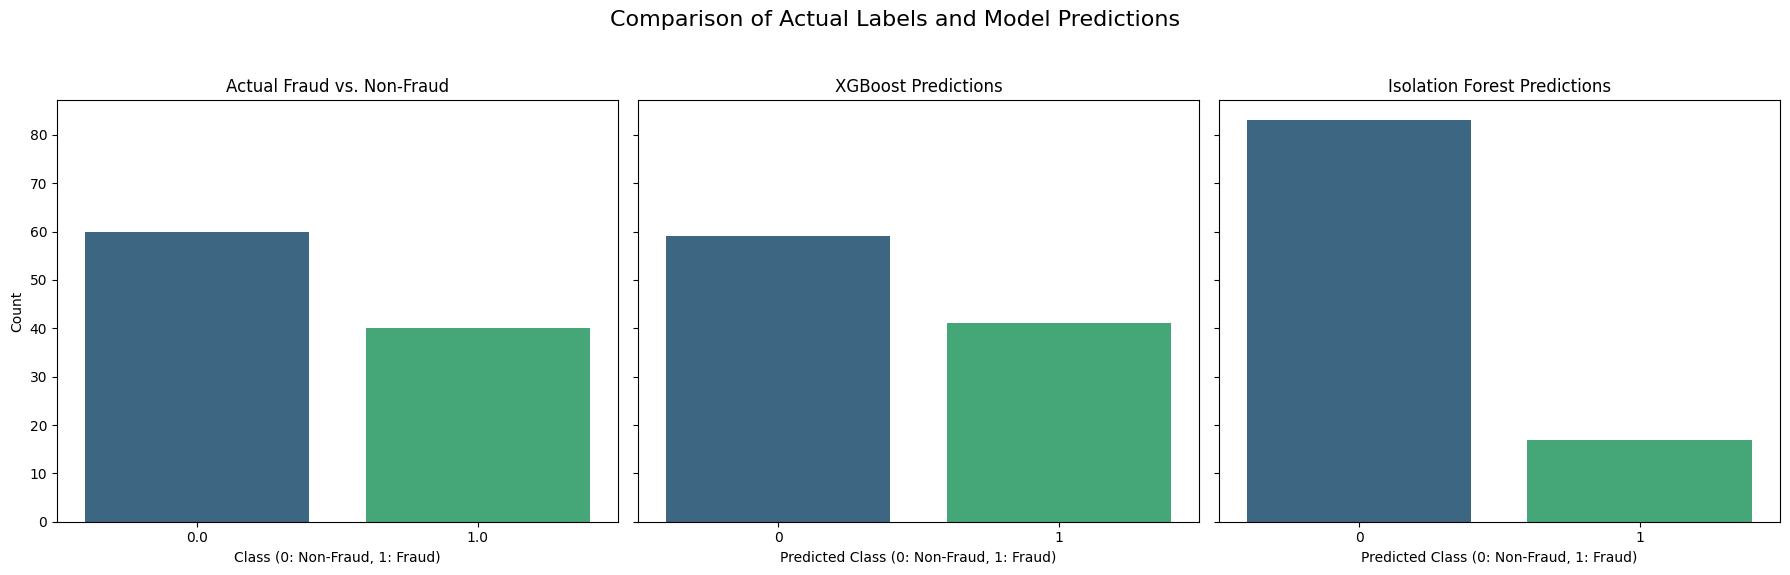

Comparative bar charts of prediction outcomes displayed.


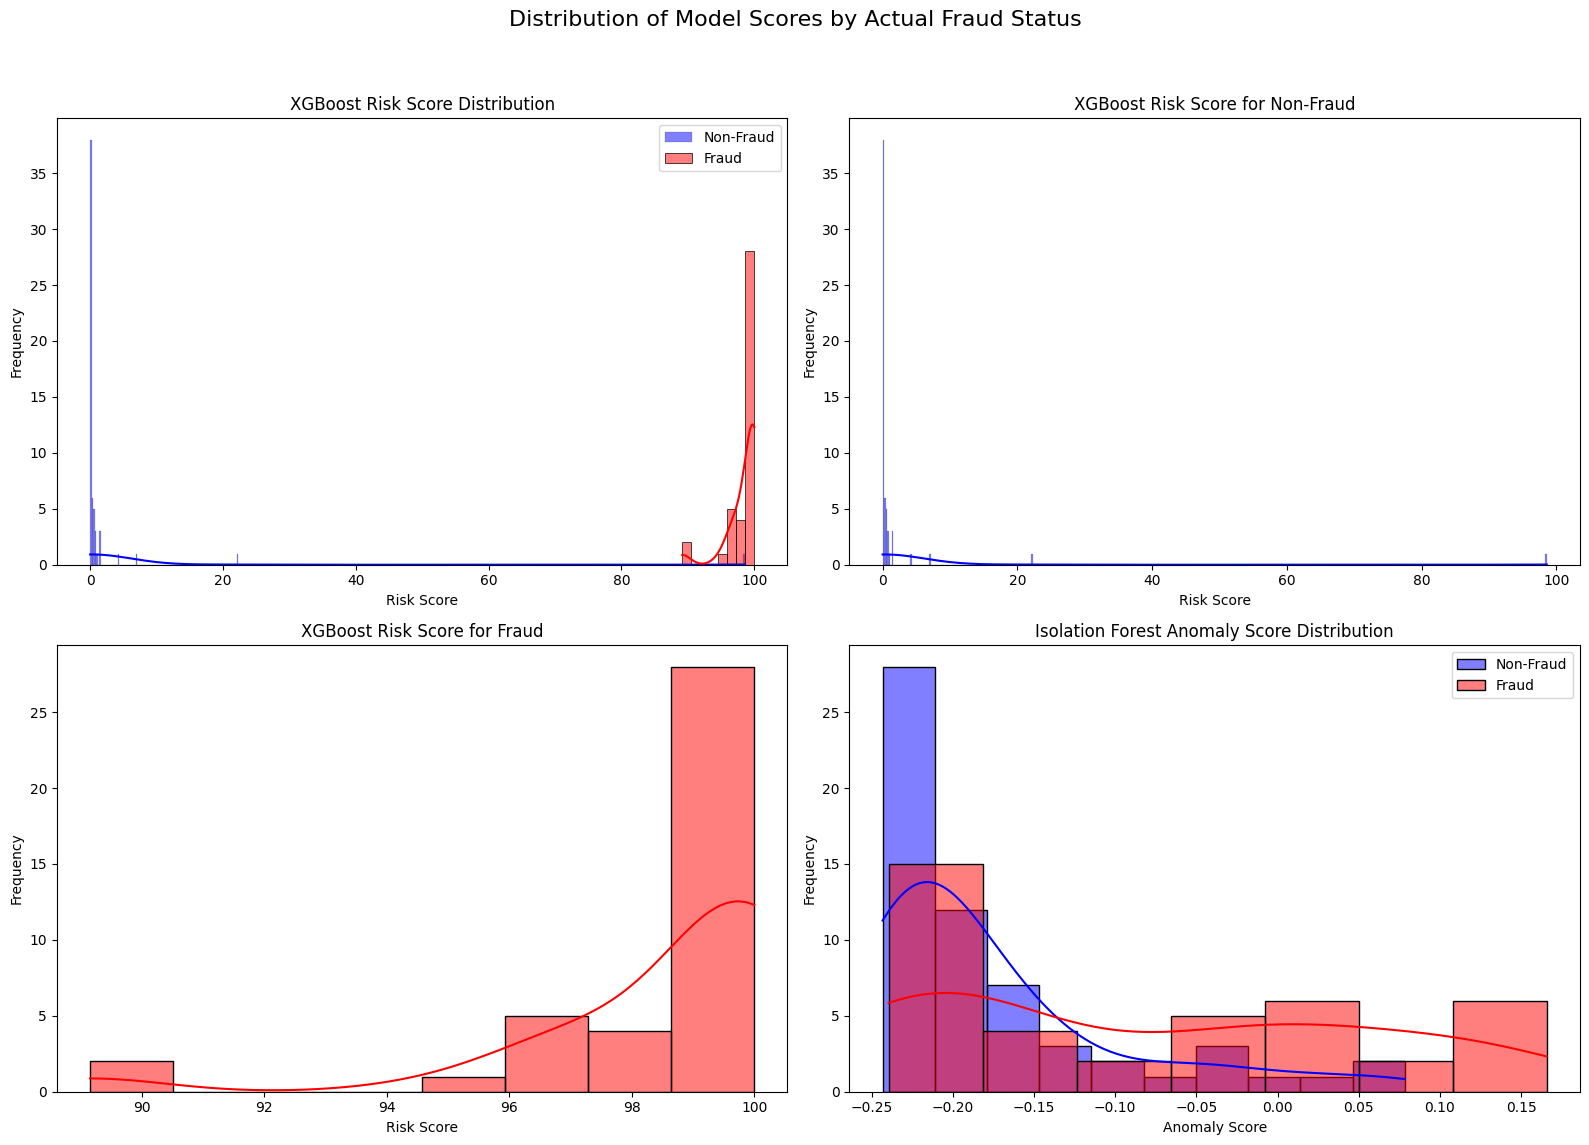

Histograms of risk/anomaly scores for fraud and non-fraud transactions displayed.


In [98]:
perform_full_model_comparison('demo_transactions.csv')